In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file, output_notebook

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

In [4]:
#conn = psycopg2.connect(host="localhost",database="mimic", user="postgres", password='postgres', port = '5432')
#cursor = conn.cursor()

In [3]:
df =pd.read_pickle('icu_features.pkl')

In [ ]:
#sql = """select * 
#from mimiciii.icu_features
#"""
#df = pd.read_sql_query(sql, conn)
#df.to_pickle("icu_features.pkl")

In [5]:
df.head()

icustay_id  hadm_id  subject_id                 age gender      height  \
0      200001   152234       55973 22290 days 19:06:12      F  167.851667   
1      200003   163557       27513 17625 days 19:50:04      M  177.800000   
2      200006   189514       10950 19736 days 11:28:14      M  165.100000   
3      200007   129310       20707 15818 days 10:03:37      M  177.800000   
4      200009   129607       29904 17353 days 10:34:32      F  160.020000   

       weight             ethnicity insurance filter_vaso    ...      \
0   27.669135  ASIAN - ASIAN INDIAN  Medicare       False    ...       
1   78.224998                 WHITE   Private        True    ...       
2   82.400002                 OTHER  Medicaid       False    ...       
3  126.000000                 WHITE   Private       False    ...       
4   85.833331                 WHITE   Private        True    ...       

  pc_bronch pc_cath pc_echo pc_pressor pc_rhc pc_thora pc_vent passed_filters  \
0       0.0     0.0     0.0        0.0    0.0      0.0     0.0            NaN   
1       0.0     0.0     0.0        0.0    0.0      0.0     0.0            1.0   
2       NaN     NaN     NaN        NaN    NaN      NaN     NaN            NaN   
3       NaN     NaN     NaN        NaN    NaN      NaN     NaN            NaN   
4       0.0     0.0     0.0        0.0    0.0      0.0     0.0            NaN   

  use_record        bmi  
0        NaN   9.820741  
1        1.0  24.744692  
2        NaN  30.229647  
3        NaN  39.857223  
4        NaN  33.520264  

[5 rows x 152 columns]

In [6]:
df.columns.tolist()

['icustay_id',
 'hadm_id',
 'subject_id',
 'age',
 'gender',
 'height',
 'weight',
 'ethnicity',
 'insurance',
 'filter_vaso',
 'filter_chronic_dialysis',
 'filter_angus_sepsis',
 'filter_hard_cardiogenic',
 'filter_adult',
 'filter_echo',
 'ed_chartdate',
 'ed_charttime',
 'ed_quality',
 'ed_indication',
 'ed_bsa',
 'ed_bp',
 'ed_bpsys',
 'ed_bpdias',
 'ed_hr',
 'ed_test',
 'ed_doppler',
 'ed_contrast',
 'ea_hadm_id',
 'ea_new_time',
 'ea_key',
 'ea_height',
 'ea_weight',
 'ea_sys',
 'ea_diastolic',
 'ea_hr',
 'ea_tv_pulm_htn',
 'ea_tv_regurgitation',
 'ea_tv_stenosis',
 'ea_lv_cavity',
 'ea_lv_diastolic',
 'ea_lv_systolic',
 'ea_lv_wall',
 'ea_rv_cavity',
 'ea_rv_volume_overload',
 'ea_rv_systolic',
 'ea_rv_wall',
 'ea_av_regurgitation',
 'ea_av_stenosis',
 'ea_mv_regurgitation',
 'ea_mv_stenosis',
 'ea_la_cavity',
 'ea_ra_dilated',
 'ea_ra_pressure',
 'ex_congestive_heart_failure',
 'ex_cardiac_aarrhythmias',
 'ex_valvular_disease',
 'ex_pulmonary_circulation',
 'ex_peripheral_vascu

# calculate some new features

In [224]:
#day30_mortality = ef.ea_days_after_discharge_death <= 30
day30_mortality = (df.dod - df.intime) < np.timedelta64(30, 'D')
df['day30_mortality'] = day30_mortality

delta_creat = df.creatinine_last - df.creatinine_max;
df['delta_creat']  = delta_creat

delta_lactate = df.lactate_last - df.lactate_max;
df['delta_lactate']  = delta_lactate

had_echo = ~df['ea_key'].isnull()
df['had_echo'] = had_echo

In [229]:
#df[df['passed_filters']==1 & ~df['ea_key'].isnull()].count()

In [247]:
# define cohorts 
sepsis = df[(df['passed_filters']==1) & (df['st_nsicu']==0) & (df['use_record']==1)]
echo_sepsis = df[(df['passed_filters']==1) & (df['st_nsicu']==0) & (df['had_echo']==1) & (df['use_record']==1)]
#echo_sepsis.filter(regex= 'ea_').count()

# Echo features exploration

In [248]:
# Features from Echos
echo_sepsis = df.filter(regex='ea_')
echo_sepsis.count()

ea_hadm_id               19752
ea_new_time              19752
ea_key                   19752
ea_height                14523
ea_weight                15409
ea_sys                   16140
ea_diastolic             16068
ea_hr                    15109
ea_tv_pulm_htn           10746
ea_tv_regurgitation      16248
ea_tv_stenosis           11623
ea_lv_cavity             16022
ea_lv_diastolic           1629
ea_lv_systolic           15920
ea_lv_wall               15089
ea_rv_cavity             17057
ea_rv_volume_overload     1298
ea_rv_systolic           17189
ea_rv_wall                2151
ea_av_regurgitation      15247
ea_av_stenosis           13852
ea_mv_regurgitation      15968
ea_mv_stenosis            7666
ea_la_cavity             14820
ea_ra_dilated            11837
ea_ra_pressure            1225
dtype: int64

In [249]:
table = sepsis.groupby(['had_echo']).size()
table

had_echo
False    4128
True     3033
dtype: int64

In [250]:
# echo sepsis group mortality and lv-systolic
table = sepsis.groupby(['had_echo', 'day30_mortality']).size().unstack()
table

day30_mortality  False  True 
had_echo                     
False             2968   1160
True              2118    915

In [253]:
table /= table.sum(axis=0)
table

day30_mortality     False     True 
had_echo                           
False            0.583563  0.559036
True             0.416437  0.440964

In [255]:
table.sum(axis=1)

had_echo
False    1.142599
True     0.857401
dtype: float64

In [243]:
sepsis[sepsis['had_echo']==1].ea_lv_systolic.count()

3398

In [244]:
sepsis['subject_id'].unique().size

7498

In [141]:
# echo sepsis group mortality and lv-systolic
table = df[df['passed_filters']==1].groupby(['day30_mortality', 'ea_lv_systolic']).size().unstack()
table

ea_lv_systolic   -3.0  -2.0  -1.0   0.0   1.0   2.0   3.0
day30_mortality                                          
False              26    63   267  2370   192   136   190
True               15    43   160   766    65    65   106

In [142]:
table /= table.sum(axis=0)
table

ea_lv_systolic       -3.0     -2.0      -1.0      0.0       1.0       2.0  \
day30_mortality                                                             
False            0.634146  0.59434  0.625293  0.75574  0.747082  0.676617   
True             0.365854  0.40566  0.374707  0.24426  0.252918  0.323383   

ea_lv_systolic        3.0  
day30_mortality            
False            0.641892  
True             0.358108

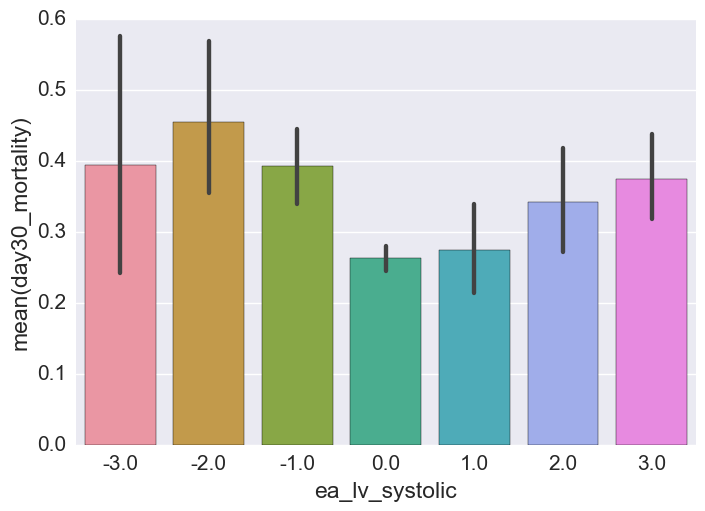

In [143]:
sns.set(font_scale=1.5)
sns.barplot(x="ea_lv_systolic", y ="day30_mortality", data = echo_sepsis)

In [144]:
# echo sepsis group mortality and lv-systolic
table = df[df['passed_filters']==1].groupby(['day30_mortality', 'ea_lv_diastolic']).size().unstack()
table

ea_lv_diastolic  -50.0  -3.0   -2.0    0.0    1.0    2.0    3.0 
day30_mortality                                                 
False              1.0   38.0  141.0  181.0   31.0   17.0   10.0
True               NaN   18.0   50.0   29.0    7.0    7.0    2.0

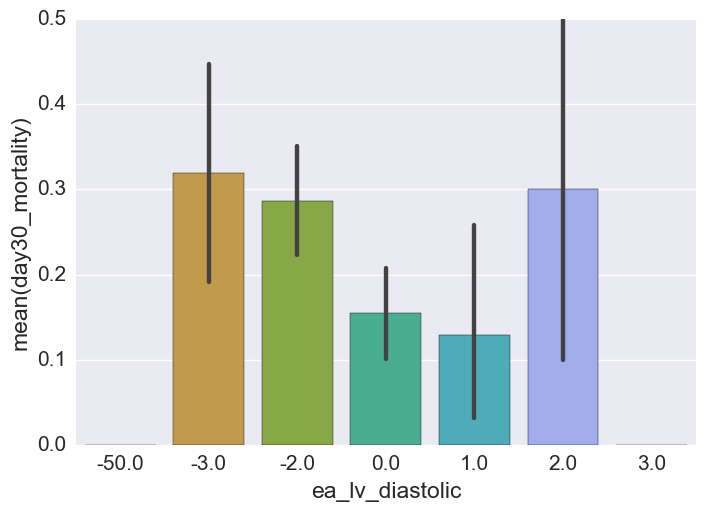

In [145]:
sns.set(font_scale=1.5)
sns.barplot(x="ea_lv_diastolic", y ="day30_mortality", data = echo_sepsis)

In [146]:
# echo sepsis group mortality 
table = df[df['passed_filters']==1].groupby(['day30_mortality', 'ea_tv_pulm_htn']).size().unstack()
table

ea_tv_pulm_htn   -50.0  -3.0    0.0    1.0    2.0    3.0 
day30_mortality                                          
False              1.0  638.0  504.0  912.0  683.0   74.0
True               NaN  172.0  141.0  337.0  351.0   51.0

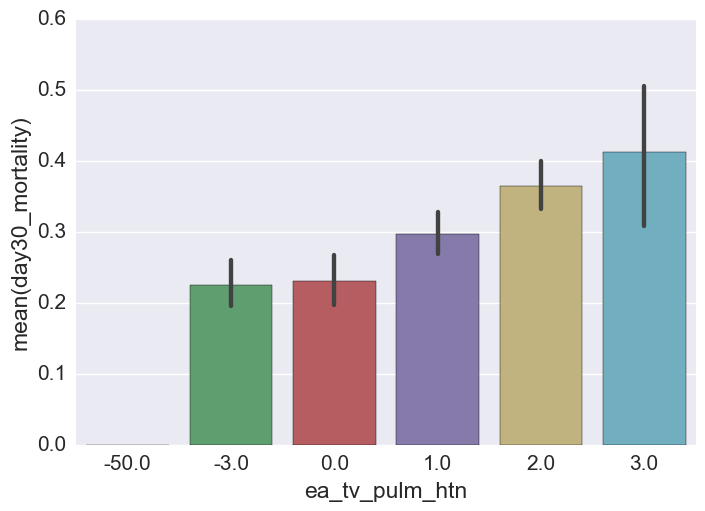

In [147]:
sns.set(font_scale=1.5)
sns.barplot(x="ea_tv_pulm_htn", y ="day30_mortality", data = echo_sepsis)

In [18]:
df.passed_filters.head()
# ((filter_vaso = True) OR (filter_angus_sepsis = True)) AND
#        (filter_hard_cardiogenic = False) AND
#        (filter_chronic_dialysis = False) AND
#        (filter_adult = True) AND
#        ((st_micu = True) OR (st_sicu = True) OR (st_nsicu = True))

0    NaN
1    1.0
2    NaN
3    NaN
4    NaN
Name: passed_filters, dtype: float64

lv_systolic.txt: 
====-3
Cannot assess LVEF
LV not well seen
Overall left ventricular systolic function cannot be reliably assessed
The left ventricle is not well seen
====-2
depressed LVEF
Depressed LVEF
global LV hypokinesis
Intrinsic LV systolic function depressed given the severity of valvular regurgitation
Intrinsic LV systolic function likely depressed given the of valvular regurgitation
Intrinsic LV systolic function likely depressed given the severity of regurgitation
Intrinsic LV systolic function likely depressed given the severity of valvular regurgitation
LV systolic function appears depressed
====-1
Hyperdynamic left ventricular systolic function
Hyperdynamic LVEF
Hyperdynamic LVEF (>75%)
Hyperdynamic LVEF >75%
Left ventricular systolic function is hyperdynamic (EF>75%)
====0
Left ventricular wall thickness, cavity size, and systolic function are normal
Left ventricular wall thickness, cavity size, and systolic function are normal (LVEF>55%)
Low normal LVEF
Low normal LVEF (50-55%)
Mild symmetric LVH with normal cavity size and global systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and regional/global systolic function (LVEF>55%)
Mild symmetric LVH with normal cavity size and systolic function (LVEF>55%)
Normal LV wall thickness, cavity size and regional/global function (LVEF >55%)
Normal LV wall thickness, cavity size and regional/global systolic function (LVEF >55%)
Normal LV wall thickness, cavity size, and global function (LVEF>55%)
Normal LV wall thickness, cavity size, and global systolic function (LVEF>55%)
Normal LV wall thickness, cavity size, and systolic function (LVEF>55%)
Overall left ventricular systolic function is low normal (LVEF 50-55%)
Overall left ventricular systolic function is normal (LVEF>55%)
Overall normal LVEF (>55%)
There is mild symmetric left ventricular hypertrophy with normal cavity size and systolic function
There is mild symmetric left ventricular hypertrophy with normal cavity size and systolic function (LVEF>55%)
====1
Mild global LV hypokinesis
Mildly depressed LVEF
Mildly depressed LVEF (40-55%)
Mildly depressed LVEF Mild global LV hypokinesis
Overall left ventricular systolic function is mildly depressed
There is mild global left ventricular hypokinesis
====2
Mild-moderate global left ventricular hypokinesis
Moderate global LV hypokinesis
Moderately depressed
Moderately depressed LVEF
Moderately depressed LVEF (30-39%)
Overall left ventricular systolic function is moderately depressed
There is moderate global left ventricular hypokinesis
====3
Moderate-severe global left ventricular hypokinesis
Overall left ventricular systolic function is severely depressed
Overall left ventricular systolic function is severely depressed -severe global left ventricular hypokinesis
severe global left ventricular hypokinesis
Severe global LV hypokinesis
Severely depressed LVEF
Severely depressed LVEF (<30%)
There is severe global left ventricular hypokinesis

In [45]:
echo_df.describe()

C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


ea_hadm_id         ea_key     ea_height     ea_weight        ea_sys  \
count   19752.00000   19752.000000  14523.000000  15409.000000  16140.000000   
mean   150073.57336   78514.901478     66.609654    180.587384    121.055266   
std     28936.73554   12636.196623      4.435277     53.869935     38.260757   
min    100003.00000   55178.000000     11.000000     10.000000     10.000000   
25%             NaN            NaN           NaN           NaN           NaN   
50%             NaN            NaN           NaN           NaN           NaN   
75%             NaN            NaN           NaN           NaN           NaN   
max    199998.00000  100971.000000     97.000000    785.000000    990.000000   

       ea_diastolic         ea_hr  ea_tv_pulm_htn  ea_tv_regurgitation  \
count  16068.000000  15109.000000    10746.000000         16248.000000   
mean      64.354244     83.893970        0.224921             0.521849   
std       36.084834     22.747684        2.015929             3.233875   
min       10.000000     32.000000      -50.000000           -50.000000   
25%             NaN           NaN             NaN                  NaN   
50%             NaN           NaN             NaN                  NaN   
75%             NaN           NaN             NaN                  NaN   
max      963.000000    833.000000        3.000000             3.000000   

       ea_tv_stenosis       ...        ea_rv_volume_overload  ea_rv_systolic  \
count    11623.000000       ...                  1298.000000    17189.000000   
mean        -0.223866       ...                    -1.129430       -0.037233   
std          0.909684       ...                     1.996577        1.389691   
min        -50.000000       ...                    -3.000000      -50.000000   
25%               NaN       ...                          NaN             NaN   
50%               NaN       ...                          NaN             NaN   
75%               NaN       ...                          NaN             NaN   
max          2.000000       ...                     1.000000        3.000000   

        ea_rv_wall  ea_av_regurgitation  ea_av_stenosis  ea_mv_regurgitation  \
count  2151.000000         15247.000000    13852.000000         15968.000000   
mean     -0.782892             0.515839        0.340962             0.848009   
std       1.594994             1.008098        1.269669             1.867941   
min      -3.000000           -50.000000      -50.000000           -50.000000   
25%            NaN                  NaN             NaN                  NaN   
50%            NaN                  NaN             NaN                  NaN   
75%            NaN                  NaN             NaN                  NaN   
max       1.000000             3.000000        3.000000             3.000000   

       ea_mv_stenosis  ea_la_cavity  ea_ra_dilated  ea_ra_pressure  
count     7666.000000  14820.000000   11837.000000     1225.000000  
mean         0.028698      0.303914       0.448255        0.292245  
std          0.672029      1.509517       0.497336        1.454477  
min        -50.000000    -50.000000       0.000000       -3.000000  
25%               NaN           NaN            NaN             NaN  
50%               NaN           NaN            NaN             NaN  
75%               NaN           NaN            NaN             NaN  
max          3.000000      3.000000       1.000000        2.000000  

[8 rows x 25 columns]

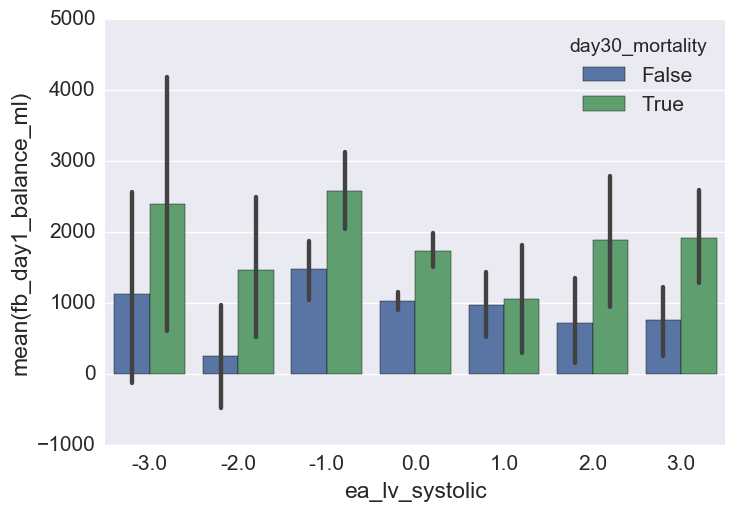

In [148]:
#plt.scatter(df.ea_lv_systolic, df.creatinine_max)
sns.barplot(x="ea_lv_systolic", y="fb_day1_balance_ml", hue = 'day30_mortality', data=echo_sepsis);

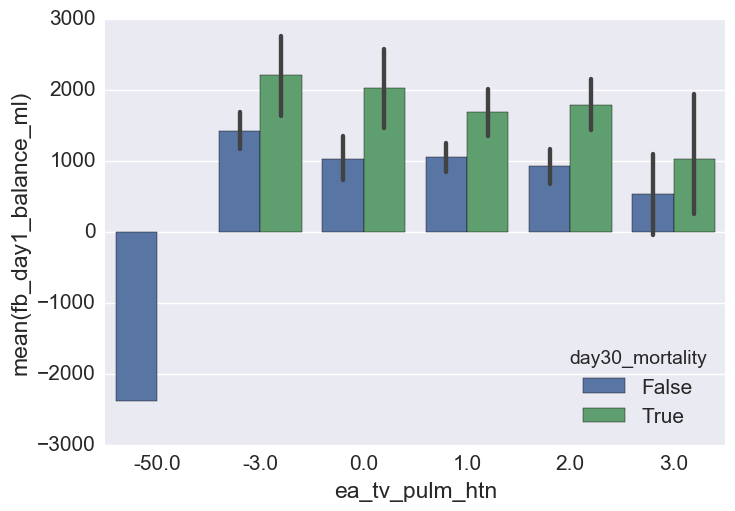

In [149]:
sns.barplot(x="ea_tv_pulm_htn", y="fb_day1_balance_ml", hue = 'day30_mortality', data=echo_sepsis);

In [ ]:
@ echo use and mortality?? 
sns.barplot(x="ea_lv_systolic", y="day30_mortality", hue = 'echo_use', data=df);

In [150]:
#echo_sepsis.filter(regex= 'ea_*_*').columns.tolist()
echo_feature_names = ['ea_tv_pulm_htn',
 'ea_tv_regurgitation',
 'ea_tv_stenosis',
 'ea_lv_cavity',
 'ea_lv_diastolic',
 'ea_lv_systolic',
 'ea_lv_wall',
 'ea_rv_cavity',
 'ea_rv_volume_overload',
 'ea_rv_systolic',
 'ea_rv_wall',
 'ea_av_regurgitation',
 'ea_av_stenosis',
 'ea_mv_regurgitation',
 'ea_mv_stenosis',
 'ea_la_cavity',
 'ea_ra_dilated',
 'ea_ra_pressure']

In [151]:
echo_feature_names.count

<function list.count>

# echo features and fluid balance

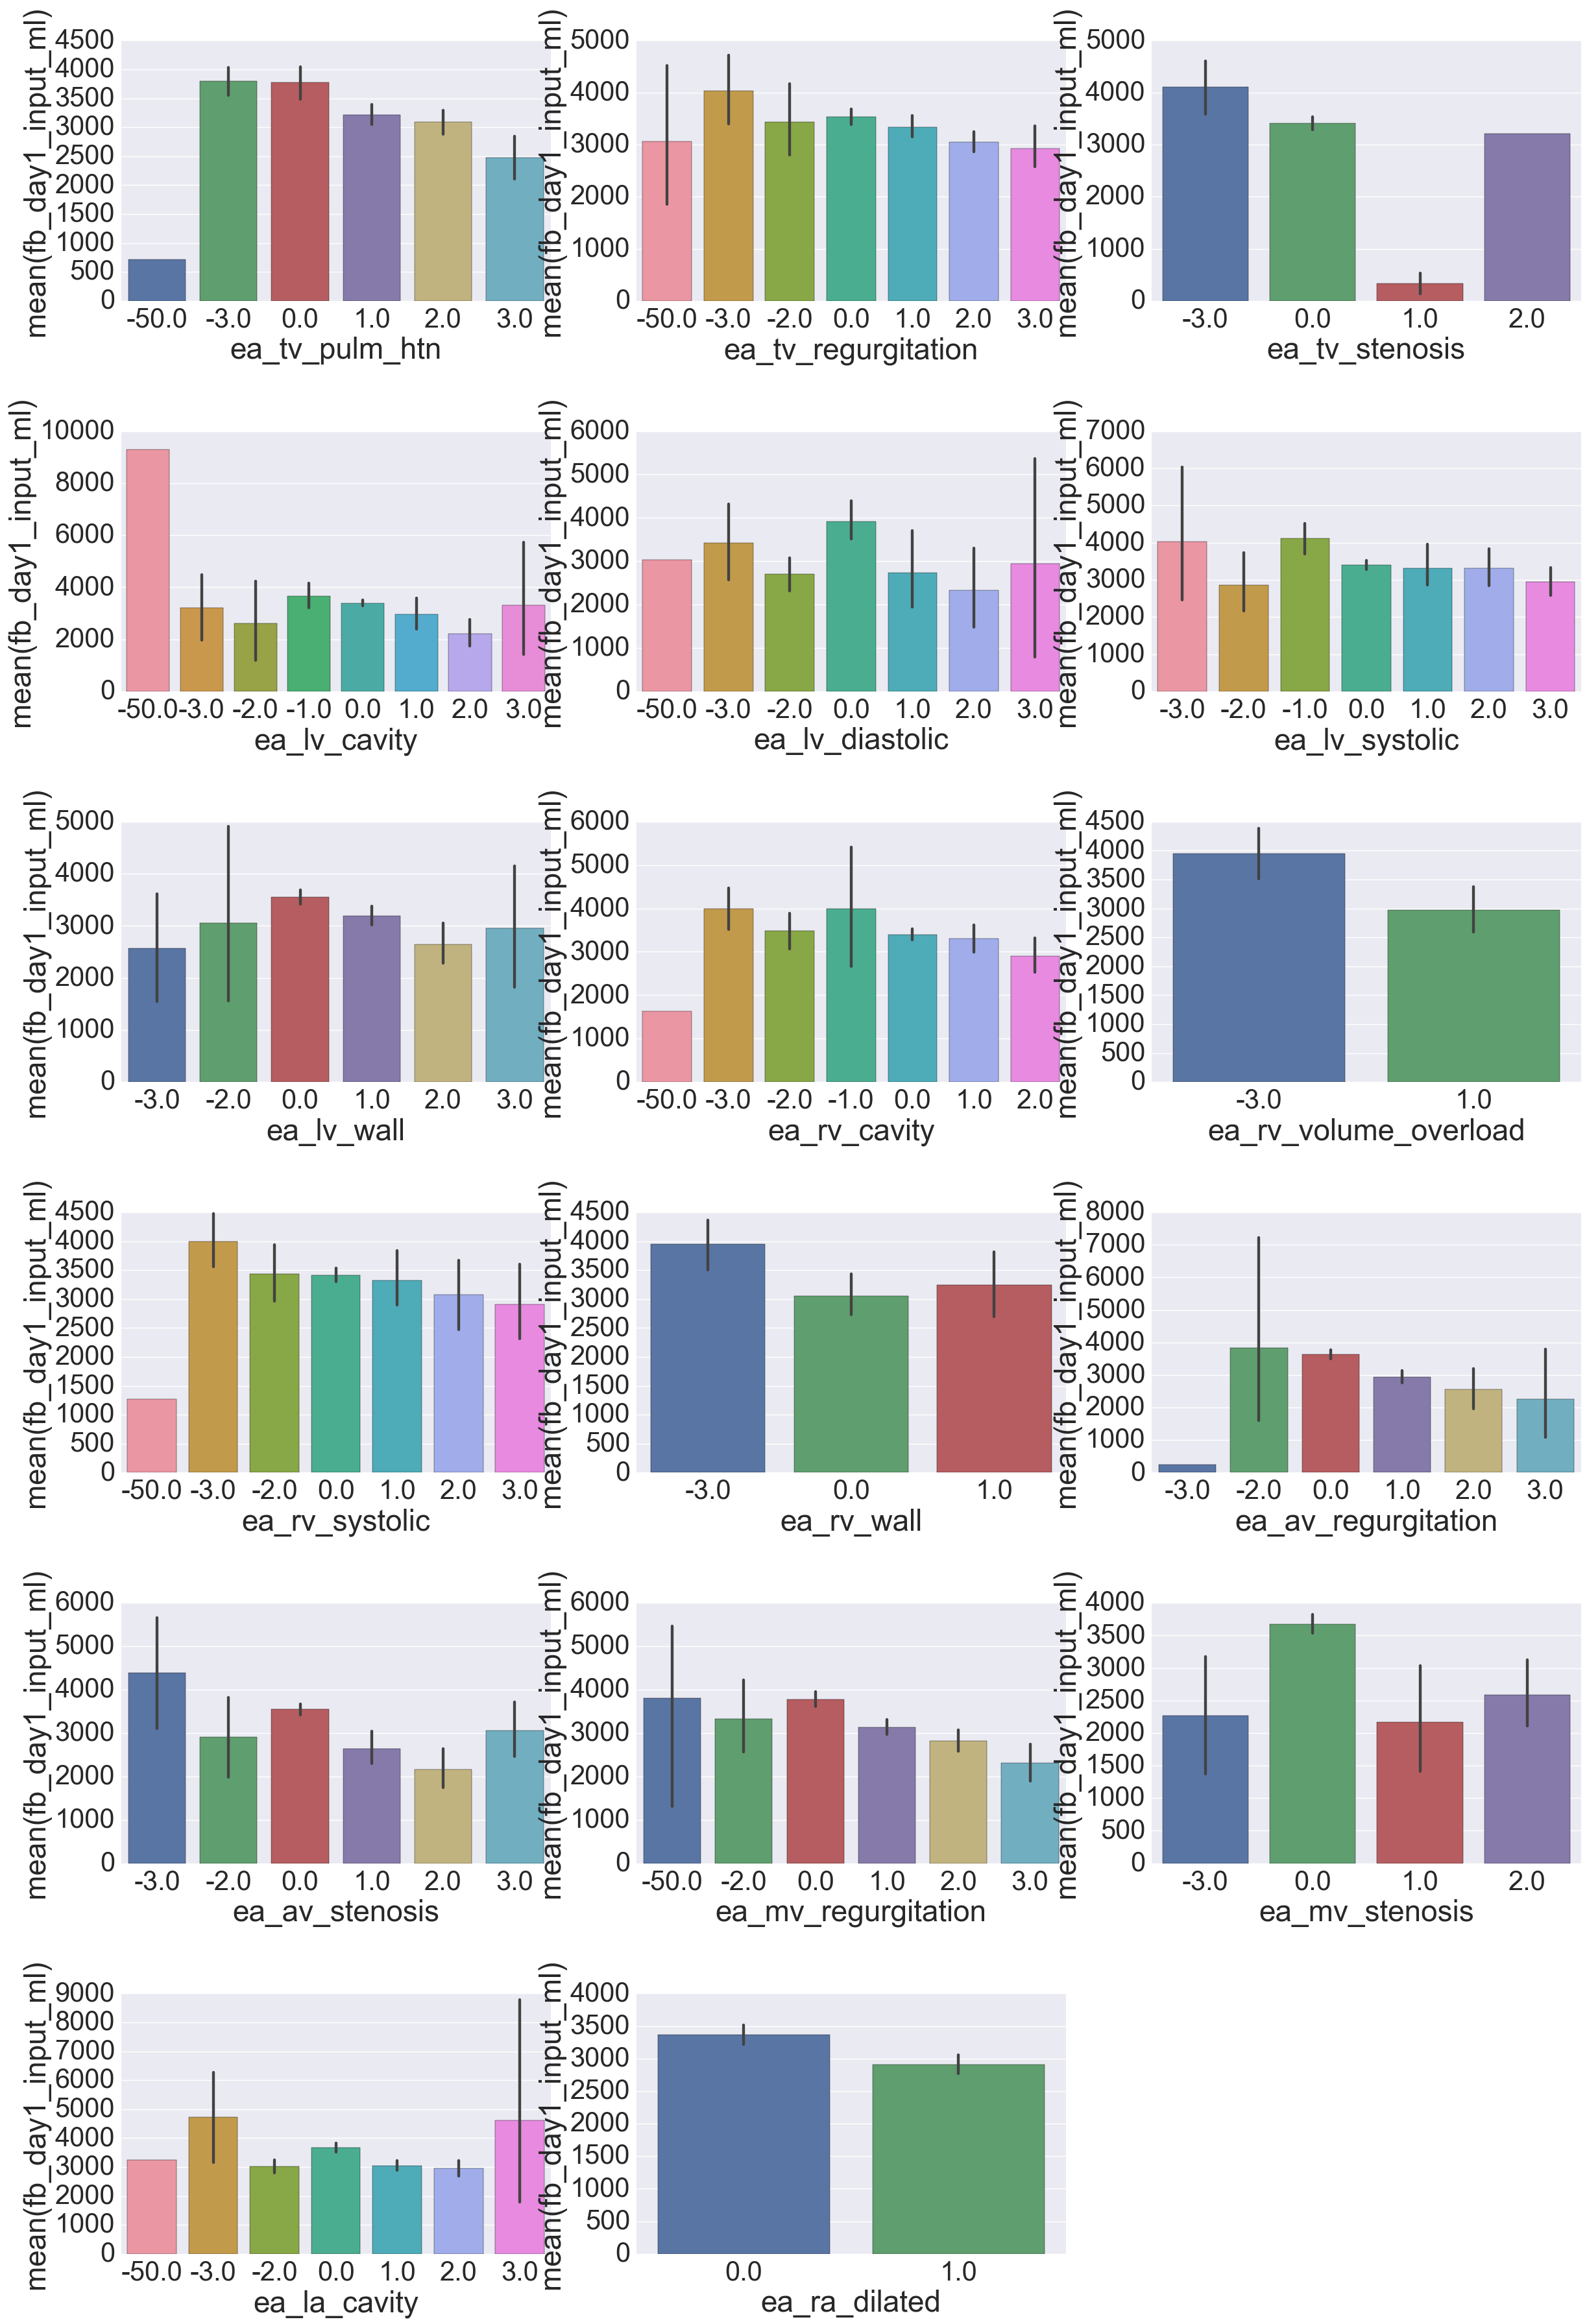

In [167]:
# most interesting are pulm_htn, and lv_systolic
nrows, ncols = 6, 3
#x = np.linspace(0,10,100)

fig = plt.figure(figsize = (12,7))  
sns.set(font_scale=3)
for i in range(1,18):
    cur_ax = fig.add_subplot(nrows, ncols, i)
    #ax.plot(x, x**i)
    sns.barplot(x= echo_feature_names[i-1], y ="fb_day1_input_ml", data = echo_sepsis, ax = cur_ax)
    #cur_ax.set_title(echo_feature_names[i])
    cur_ax.set_title(' ')
fig.subplots_adjust(right=2, top = 5, hspace = 0.5)
plt.show()

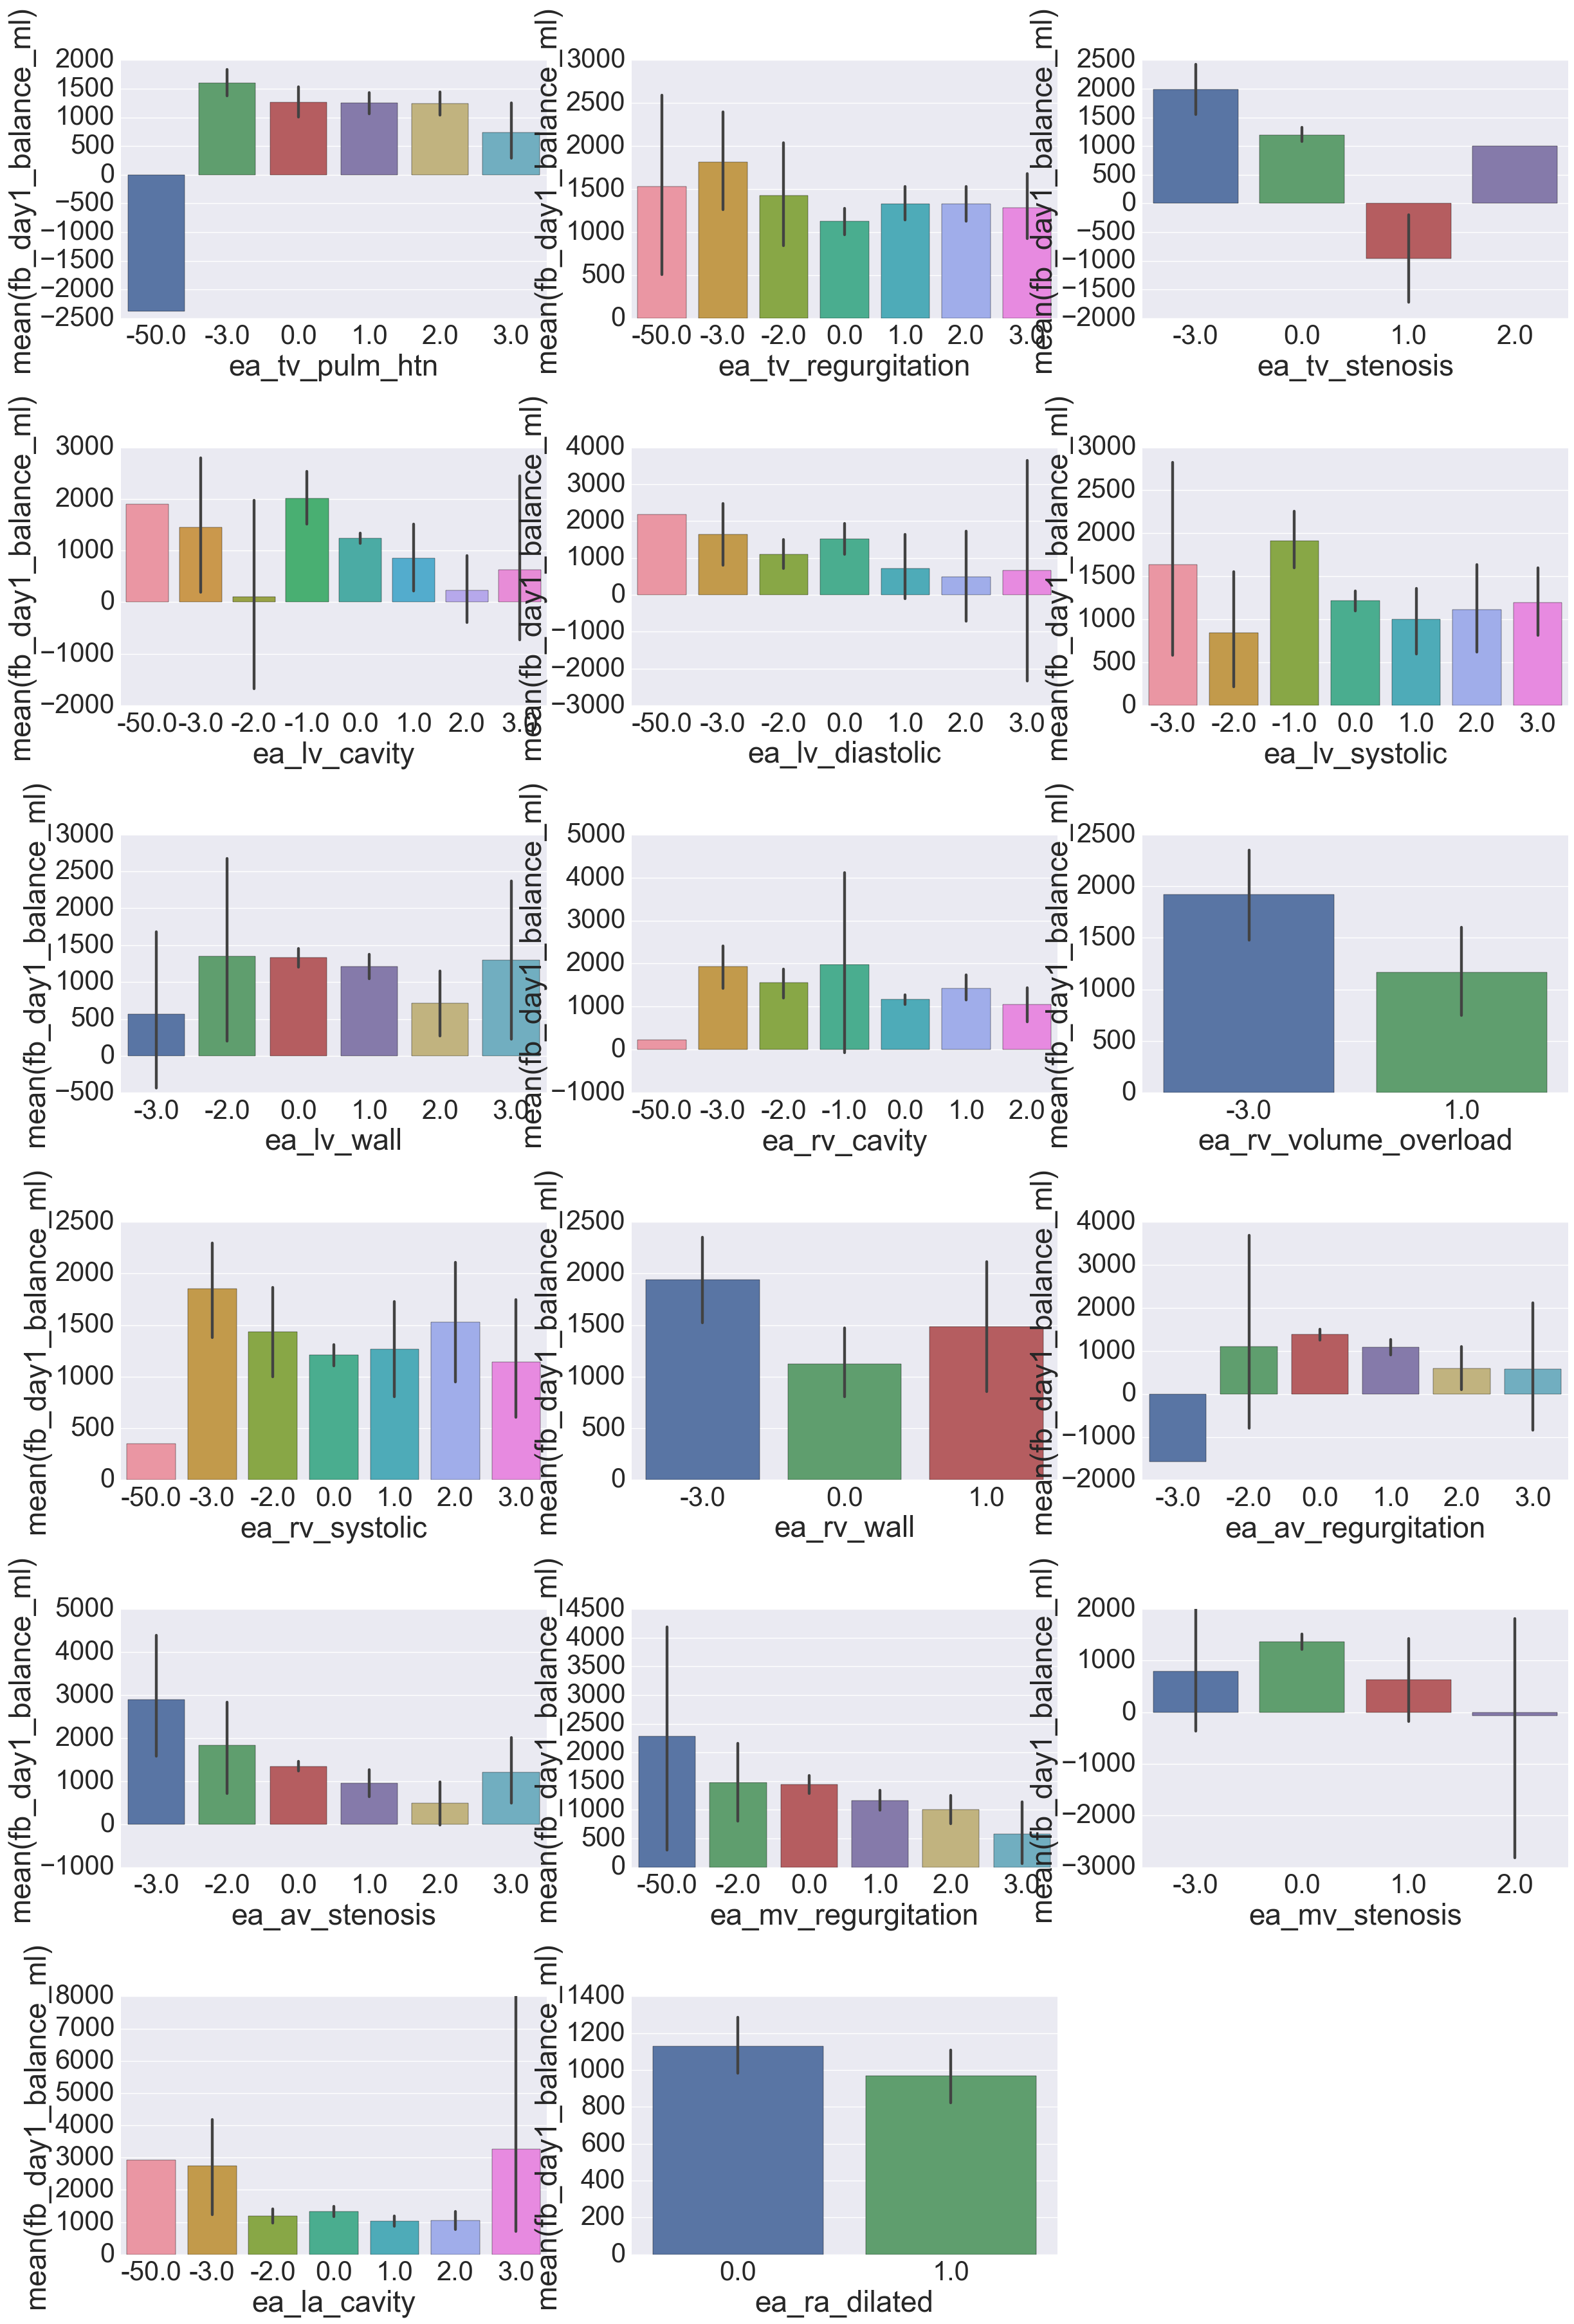

In [166]:
# most interesting are pulm_htn, and lv_systolic
nrows, ncols = 6, 3
#x = np.linspace(0,10,100)

fig = plt.figure(figsize = (12,7))  
sns.set(font_scale=3)
for i in range(1,18):
    cur_ax = fig.add_subplot(nrows, ncols, i)
    #ax.plot(x, x**i)
    sns.barplot(x= echo_feature_names[i-1], y ="fb_day1_balance_ml", data = echo_sepsis, ax = cur_ax)
    #cur_ax.set_title(echo_feature_names[i])
    cur_ax.set_title(' ')
fig.subplots_adjust(right=2, top = 5, hspace = 0.5)
plt.show()

# Mortality and echo features

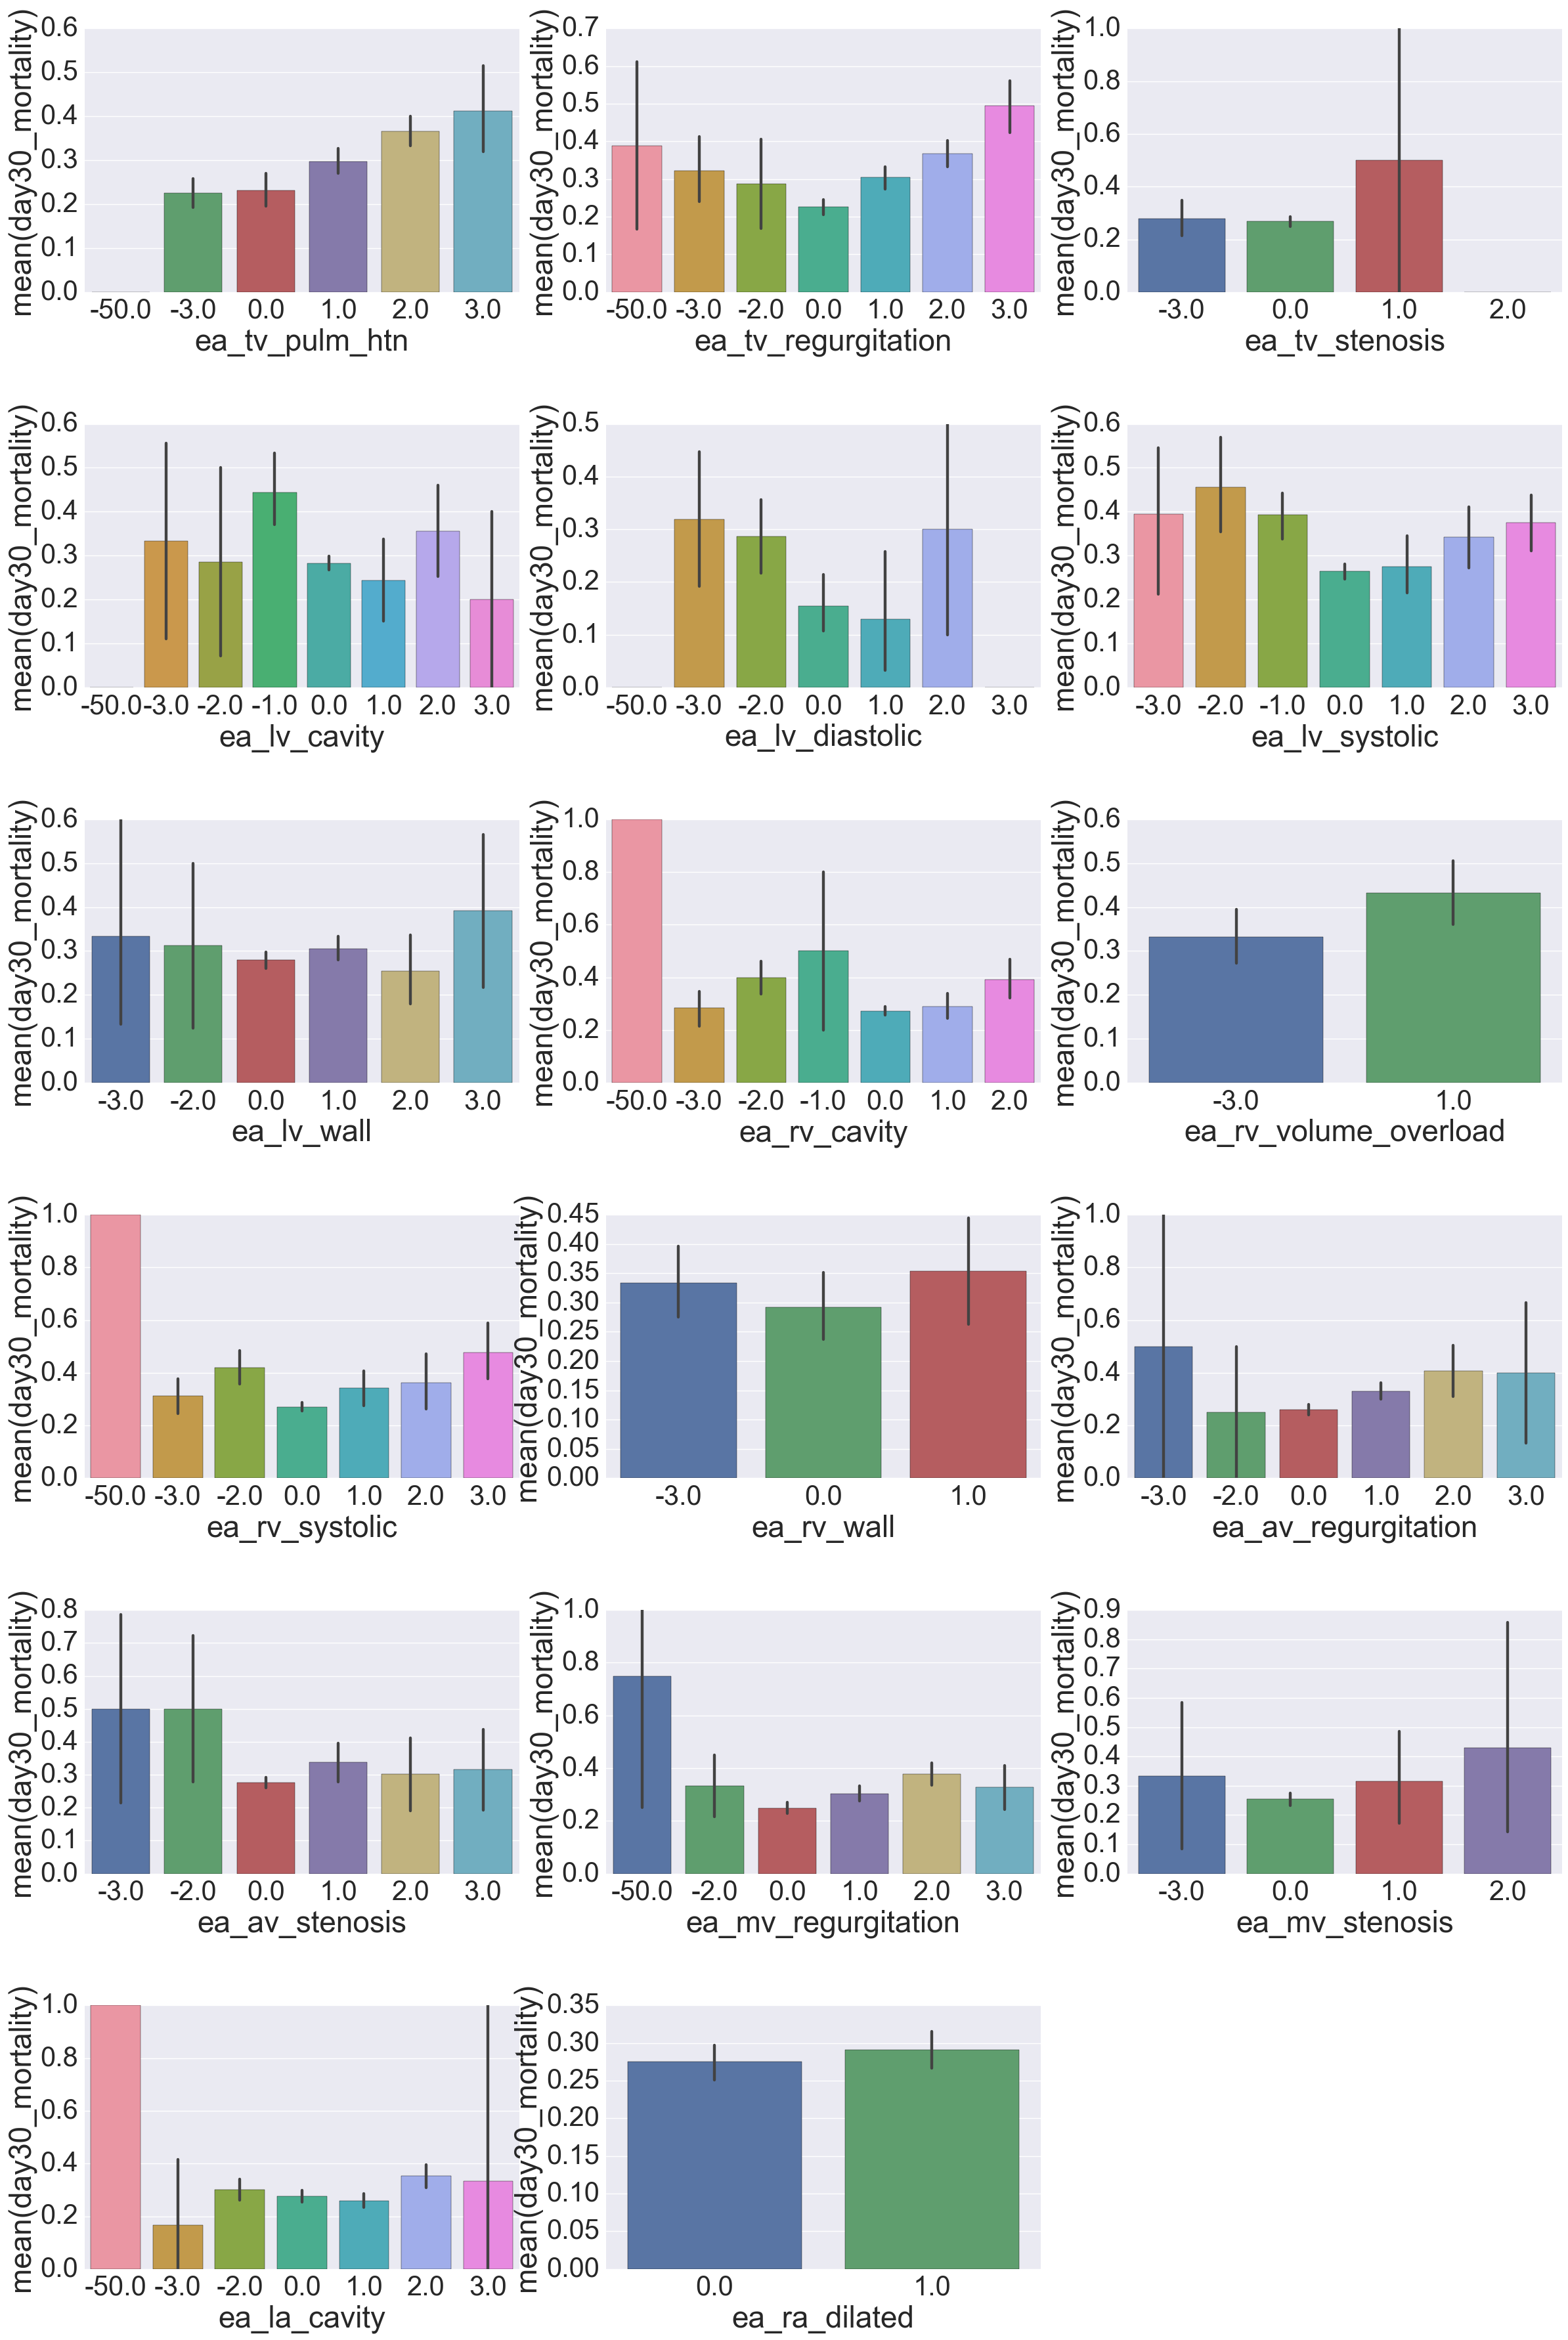

In [152]:
# most interesting are pulm_htn, and lv_systolic
nrows, ncols = 6, 3
#x = np.linspace(0,10,100)

fig = plt.figure(figsize = (12,7))  
sns.set(font_scale=3)
for i in range(1,18):
    cur_ax = fig.add_subplot(nrows, ncols, i)
    #ax.plot(x, x**i)
    sns.barplot(x= echo_feature_names[i-1], y ="day30_mortality", data = echo_sepsis, ax = cur_ax)
    #cur_ax.set_title(echo_feature_names[i])
    cur_ax.set_title(' ')
fig.subplots_adjust(right=2, top = 5, hspace = 0.5)
plt.show()

# More fluid associated with higher mortality.  

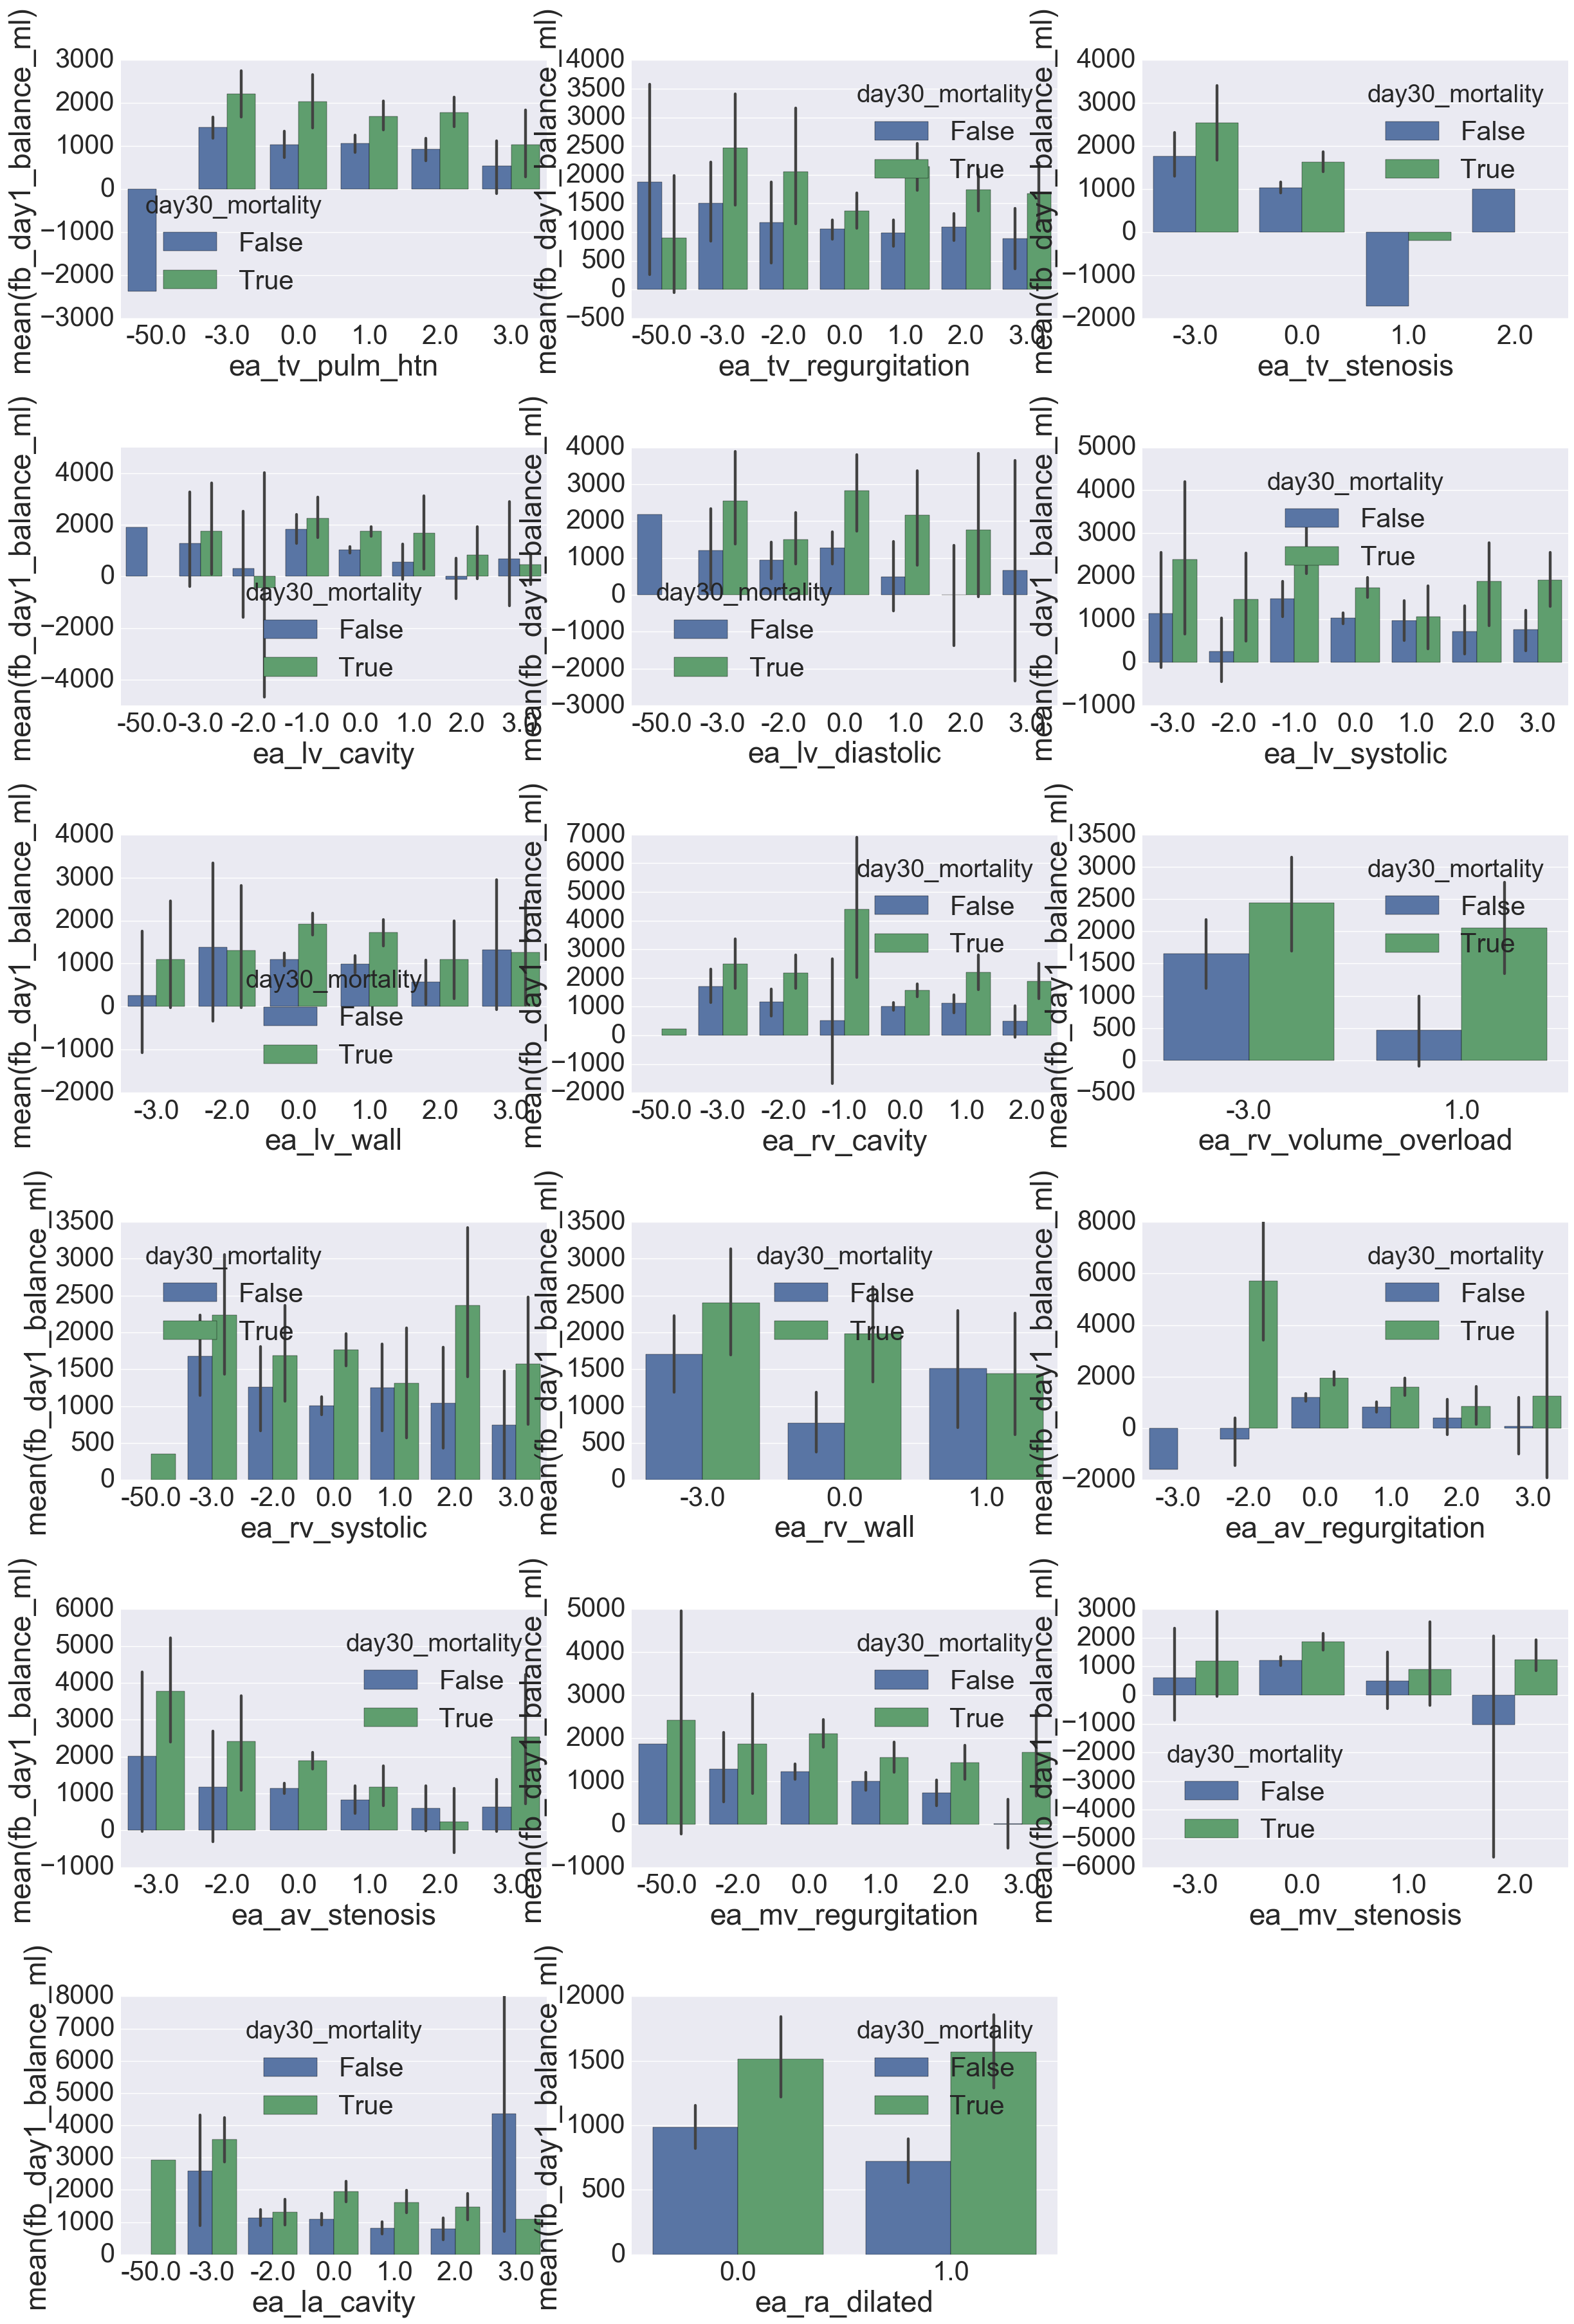

In [164]:
# tv_regurgitation, lV_systolic, 
nrows, ncols = 6, 3
#x = np.linspace(0,10,100)

fig = plt.figure(figsize = (12,7))  
sns.set(font_scale=3)
for i in range(1,18):
    cur_ax = fig.add_subplot(nrows, ncols, i)
    #ax.plot(x, x**i)
    sns.barplot(x= echo_feature_names[i-1], y = 'fb_day1_balance_ml', hue ="day30_mortality", data = echo_sepsis, ax = cur_ax)
    #cur_ax.set_title(echo_feature_names[i])
    cur_ax.set_title(' ')
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.subplots_adjust(right=2, top = 5, hspace = 0.5)
plt.show()

In [158]:
def plot_relate_echo_feature_to(feature_name, dd):
    
    limited_echo_feature_names = ['ea_tv_pulm_htn','ea_lv_systolic']

    nrows, ncols = 1, 2
    #x = np.linspace(0,10,100)

    fig = plt.figure()  
    sns.set(font_scale=3)
    for i in range(1,3):
        cur_ax = fig.add_subplot(nrows, ncols, i)
        #ax.plot(x, x**i)
        sns.barplot(x= limited_echo_feature_names[i-1], y =feature_name,data = dd, ax = cur_ax)
        #cur_ax.set_title(echo_feature_names[i])
        cur_ax.set_title(' ')
    fig.subplots_adjust(right=2)
    plt.show()

In [159]:
def plot_relate_echo_feature_and_mortality_to(feature_name, dd):
    
    limited_echo_feature_names = ['ea_tv_pulm_htn','ea_lv_systolic']

    nrows, ncols = 1, 2
    #x = np.linspace(0,10,100)

    fig = plt.figure()  
    sns.set(font_scale=3)
    for i in range(1,3):
        cur_ax = fig.add_subplot(nrows, ncols, i)
        #ax.plot(x, x**i)
        sns.barplot(x= limited_echo_feature_names[i-1], y =feature_name, hue= 'day30_mortality',data = dd, ax = cur_ax)
        #cur_ax.set_title(echo_feature_names[i])
        cur_ax.set_title(' ')
    fig.subplots_adjust(right=2)
    plt.show()

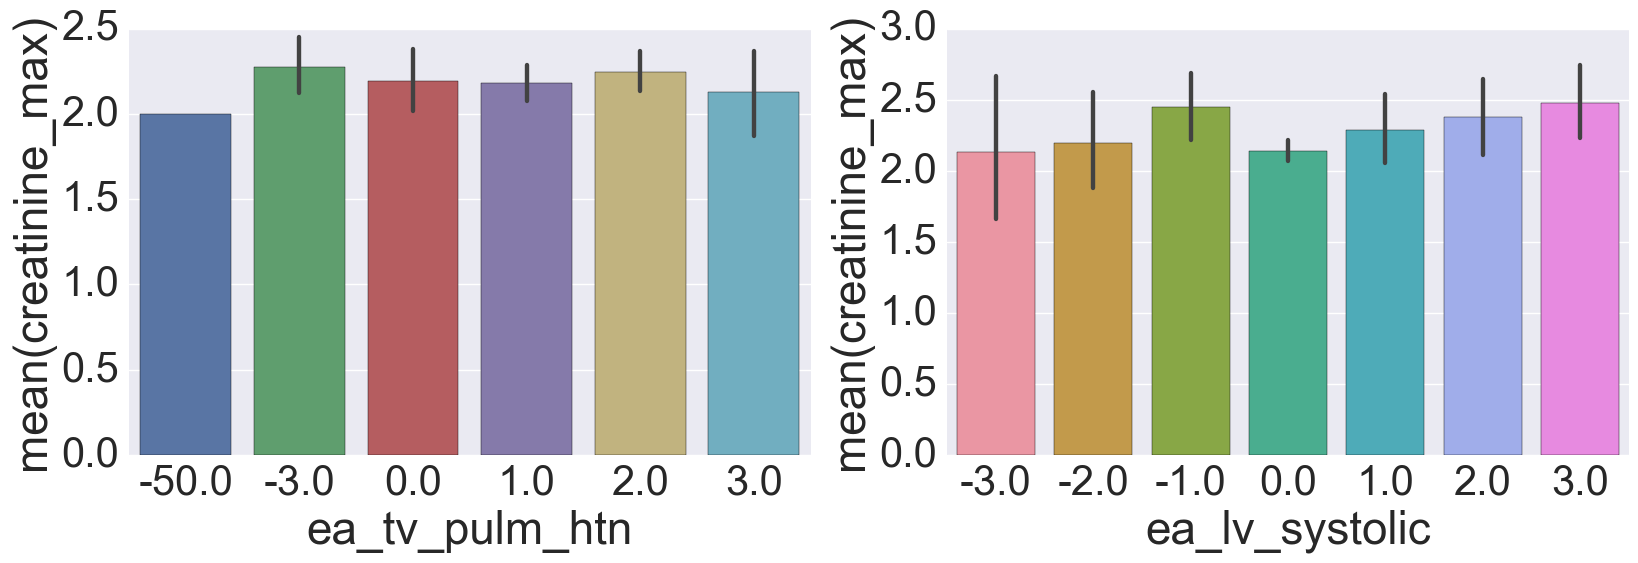

In [160]:
# higher creatinine associated with higher mortality
plot_relate_echo_feature_to('creatinine_max', echo_sepsis)

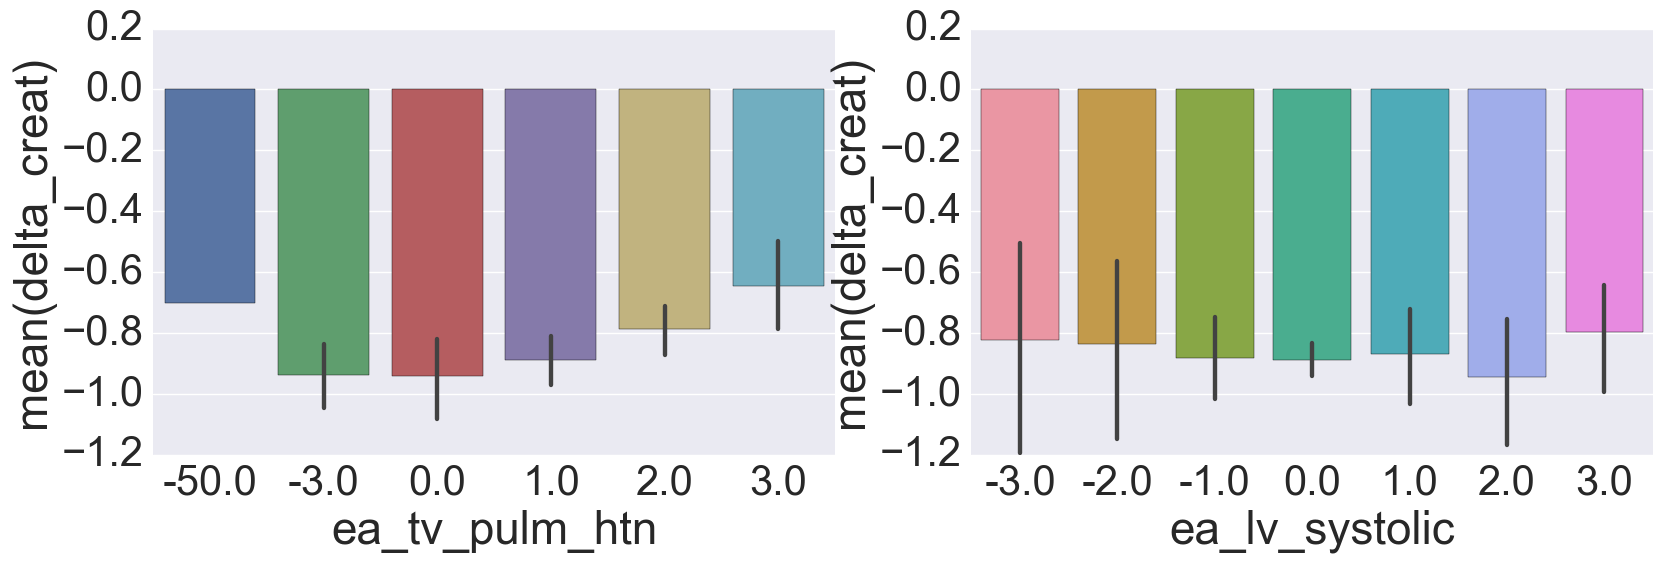

In [161]:
# smaller change in creatinine related to higher mortality.
# pulmonary hypertension predictive of creatinine change?? 
plot_relate_echo_feature_to('delta_creat', echo_sepsis)

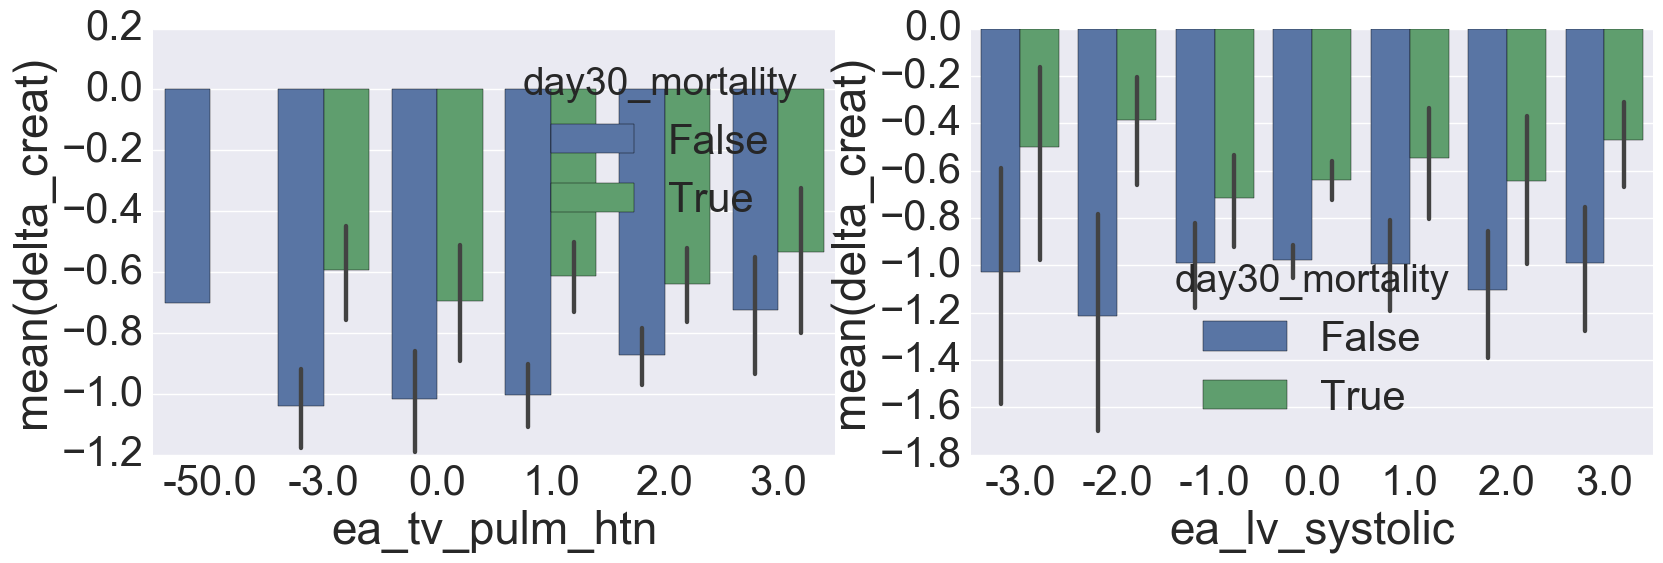

In [163]:
plot_relate_echo_feature_and_mortality_to('delta_creat', echo_sepsis)

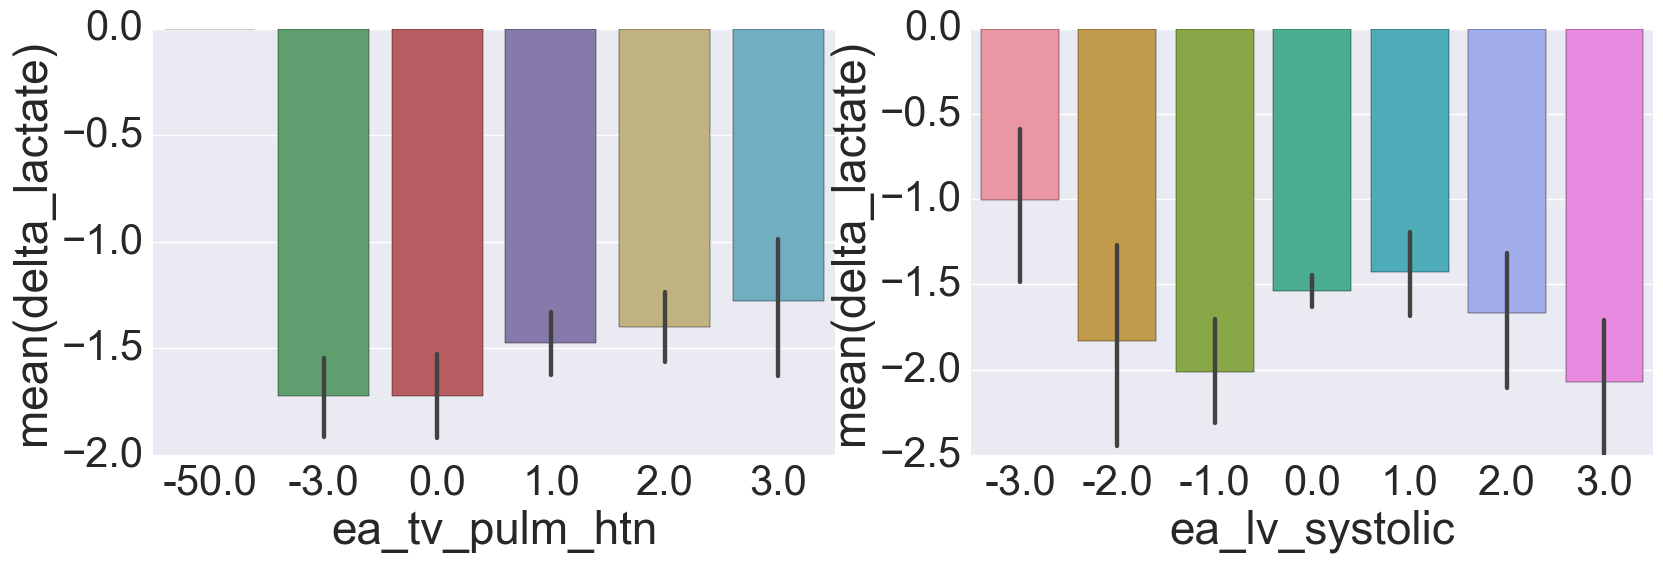

In [165]:
# higher creatinine associated with higher mortality
plot_relate_echo_feature_to('delta_lactate', echo_sepsis)